## Jupyter notebook for calculating Bayesian Information Criteria (BIC) for ATAC-seq data

This notebook is the code for calculating BIC for ATAC-seq data used in the paper **"Simultaneous analysis of open chromatin, promoter interactions and gene expression in stimulated T cells implicates causal genes for rheumatoid arthritis"** by *Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre*.

For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

### loading gptk package for Gaussian process regression

In [1]:
library(gptk)
library(ggplot2)
library(gridExtra)

Loading required package: Matrix
Loading required package: fields
Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.3-0 (2019-09-13) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following object is masked from ‘package:Matrix’:

    det

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


### read ATACseq data

In [2]:
data <- read.table('data/ATACseq_normalized.csv',sep=',',header=T)

In [3]:
head(data)

seqnames,start,end,width,T0,T20,T60,T2H,T4H,T24H
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10,100006331,100006563,233,5.004126,4.659345,5.928870,5.524712,7.401195,6.763596
chr10,100009362,100010421,1060,8.910829,8.899573,9.033632,8.848950,9.088016,8.780725
chr10,100118128,100118310,183,3.677326,5.423599,3.774964,5.181859,3.997616,4.538095
chr10,100148537,100149145,609,6.308615,5.997314,6.371118,7.022634,8.320145,8.144691
chr10,100164173,100164282,110,3.793428,3.296516,4.600715,4.917097,3.838937,5.077424
chr10,100167603,100168094,492,6.121348,5.530762,5.770208,6.469869,6.229512,5.807280


In [4]:
idx_data <- paste('T', c('0','20','60','2H','4H','24H'), sep='')


### normalized ATACseq data

In [5]:
normalized_data <- t(scale(t(data[,idx_data]), center=T, scale=T))


In [6]:
head(normalized_data)

T0,T20,T60,T2H,T4H,T24H
-0.8368876,-1.1662063,0.0463851,-0.339647805,1.4526805,0.8436761
-0.1405642,-0.2386912,0.9299352,-0.679979579,1.4040074,-1.2747076
-1.0185359,1.3375392,-0.8868026,1.011382477,-0.5863990,0.1428158
-0.7240373,-1.0376049,-0.6610797,-0.004819892,1.3021365,1.1254052
-0.6463374,-1.3436445,0.4865104,0.930482158,-0.5824759,1.1554652
0.3852845,-1.3231994,-0.6305141,1.393509512,0.6981904,-0.5232709


### use logscaled time points for GP regression 

In [7]:
times_data <- log(c(0,20,60,120,240,1440)+10)


In [8]:
x <- matrix(times_data)
lld_rbf <- numeric(0)
lld_static <- numeric(0)

for (ii in (1:dim(normalized_data)[1])) {  ## this calculation will take a long time
  y <- matrix(normalized_data[ii,])
  model0 <- list() ## Allocate space for model.
  options=gpOptions(approx="ftc")
  options$kern = list(type="cmpnd",comp=list(list(type="rbf"),list(type="white"))) ### use rbf+white nosie kernel for model 0
  ## Optimise GP log likelihoods.
  model0 <- gpCreate(dim(x)[2], dim(y)[2], x, y, options)
  model0 <- gpOptimise(model0,0)
  
  lld_rbf[ii] <- gpLogLikelihood(model0) ### loglikelihood ratio for rbf model
  
  model1 <- list() ## Allocate space for model.
  options=gpOptions(approx="ftc")
  options$kern = list(type="white") ### use white noise kernel for model 1
  ## Optimise GP log likelihoods.
  model1 <- gpCreate(dim(x)[2], dim(y)[2], x, y, options)
  model1 <- gpOptimise(model1,0)
  lld_static[ii] <- gpLogLikelihood(model1) ### loglikelihood ratio for static model
}




### an example for the 4th data point

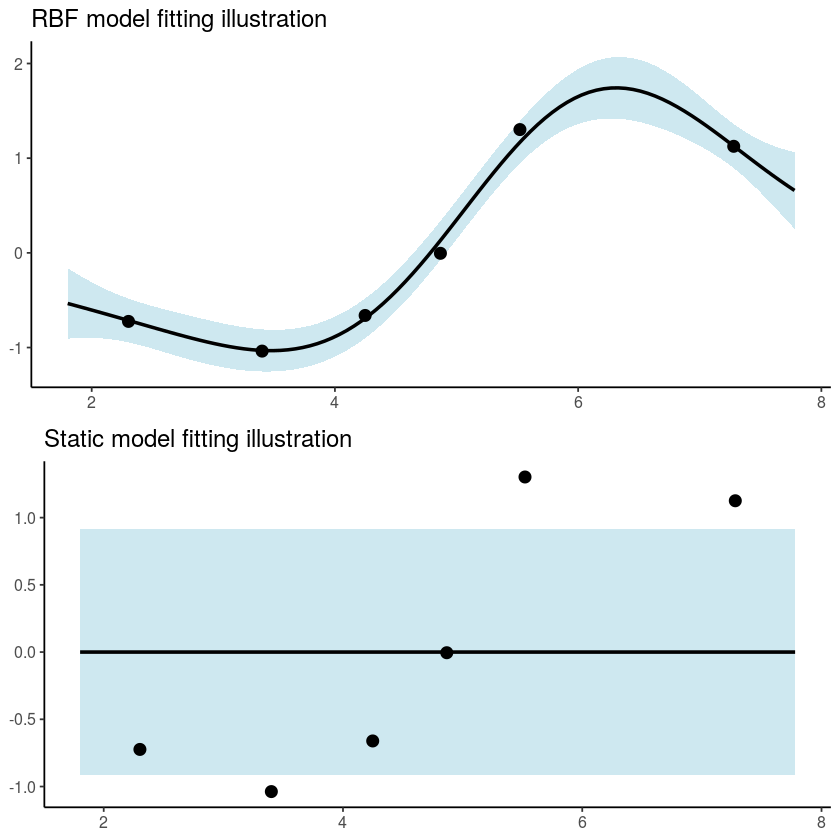

In [9]:

y <- matrix(normalized_data[4,])
model0 <- list() ## Allocate space for model.
options=gpOptions(approx="ftc")
options$kern = list(type="cmpnd",comp=list(list(type="rbf"),list(type="white"))) ### use rbf+white nosie kernel for model 0
## Optimise GP log likelihoods.
model0 <- gpCreate(dim(x)[2], dim(y)[2], x, y, options)
model0 <- gpOptimise(model0,0)
    
model1 <- list() ## Allocate space for model.
options=gpOptions(approx="ftc")
options$kern = list(type="white") ### use white noise kernel for model 1
## Optimise GP log likelihoods.
model1 <- gpCreate(dim(x)[2], dim(y)[2], x, y, options)
model1 <- gpOptimise(model1,0)


tstar <- matrix(seq(min(times_data)-0.5, max(times_data)+0.5, length=100), ncol=1)

Kx0 <- kernCompute(model0$kern, x, tstar)
Ktrain0 <- kernCompute(model0$kern, x)
invKtrain0 <- solve(Ktrain0)
yPred0 <- t(Kx0) %*% invKtrain0 %*% y
yVar0 <- diag(abs(kernCompute(model0$kern, tstar) - t(Kx0) %*% invKtrain0 %*% Kx0))
data_forplot_rbf1 <- data.frame(x=tstar, yupper = yPred0+sqrt(abs(yVar0)), ylower= yPred0-sqrt(abs(yVar0)), yPred = yPred0)
data_forplot_rbf2 <- data.frame(x=x,y=y)
p1 <- ggplot(data=data_forplot_rbf1,aes(x=tstar)) + 
   geom_ribbon(aes(ymin = ylower, ymax = yupper), fill = "lightblue", alpha=0.6) +
   geom_line(aes(y = yPred ),size=1) + geom_point(data=data_forplot_rbf2, aes(x=x,y=y),size=3) +
   theme(legend.position="none") + theme(axis.title.x=element_blank(),
        axis.title.y=element_blank(),text = element_text(size=12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black")) + xlab('Time (logscaled)') + 
ylab('Normalized data') + ggtitle('RBF model fitting illustration')


Kx1 <- kernCompute(model1$kern, x, tstar)
Ktrain1 <- kernCompute(model1$kern, x)
invKtrain1 <- solve(Ktrain1)
yPred1 <- t(Kx1) %*% invKtrain1 %*% y
yVar1 <- diag(abs(kernCompute(model1$kern, tstar) - t(Kx1) %*% invKtrain1 %*% Kx1))
data_forplot_noise1 <- data.frame(x=tstar, yupper = yPred1+sqrt(abs(yVar1)), ylower= yPred1-sqrt(abs(yVar1)), yPred = yPred1)
data_forplot_noise2 <- data.frame(x=x,y=y)


p2 <- ggplot(data=data_forplot_noise1,aes(x=tstar)) + 
   geom_ribbon(aes(ymin = ylower, ymax = yupper), fill = "lightblue", alpha=0.6) +
   geom_line(aes(y = yPred ),size=1) + geom_point(data=data_forplot_noise2, aes(x=x,y=y),size=3) +
   theme(legend.position="none") + theme(axis.title.x=element_blank(),
        axis.title.y=element_blank(),text = element_text(size=12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black")) + xlab('Time (logscaled)') + 
ylab('Normalized data') + ggtitle('Static model fitting illustration')

grid.arrange(p1,p2)


### Get Loglikelihood ratio results: LR = -2 ln( L<sub>RBF</sub> - L<sub>static</sub>)

In [10]:
LR_data <- -2*(lld_rbf-lld_static) ### loglikelihood ratio for the data 


### Get BIC results: BIC = k ln(n) -2ln(L)
k is the number of parameters used in each model, n is the sample size and L is the maximized likelihood 

In [11]:
### BIC_difference is used to compare the BIC difference between RBF model and the static model. Smaller BIC is preferred
BIC_rbf <- 2*log(6) - 2*lld_rbf
BIC_static <- log(6) - 2*lld_static
BIC_difference <- BIC_rbf - BIC_static
